# **Projekt – Hruška 239474**

First we need to import libraries and load all wavs and keys. Let's also add evaluation definition. After this we should be good to go.

In [ ]:
%%capture
# needed
import os
import re
import time
import soundfile as sf
from IPython.display import Audio
from IPython.display import display
import numpy as np
# recommended ...
from scipy import signal
from scipy.io import wavfile
from scipy.fft import fft, ifft, fftfreq
import scipy.io
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

# read data
login = "239474"
zip_file = "known" + ".zip"
for name in ("known.zip", "valid.zip", login + ".zip"):
  file = "https://www.fit.vut.cz/study/course/ISS/public/proj2025-26/" + name
  !rm $name
  !wget $file
  !unzip -o -q $name

  # load the known data - the function returns a big matrix with all the signals
def load_data (S, dirname, count, no_samples):
  ii = 0
  for one in np.arange(count):
    S[ii], Fs = sf.read(dirname + "/" + str(one) + ".wav")
    ii = ii+1

Fs = 16000
# load known data
N_known = 706; duration_known = 10; no_samples_known = Fs * duration_known
known_signals=np.zeros([N_known, no_samples_known]); load_data(known_signals, "known", N_known, no_samples_known)
#display(Audio(known_signals[45], rate=Fs))

# load validation data
N_valid = 50; duration_valid = 5; no_samples_valid = Fs * duration_valid
valid_signals=np.zeros([N_valid, no_samples_valid]); load_data(valid_signals, "valid", N_valid, no_samples_valid)
#display(Audio(valid_signals[45], rate=Fs))

# load the key
key = np.loadtxt("valid/key.txt", delimiter = ',', usecols=(1), dtype ='int')

# evaluation - the function produces Top-1 and Top-5 accuracy on validation data
def eval(scores, key):
  indices = np.flip(np.argsort(scores), axis=-1) # we want highest to lowest ...
  #print(scores[0,key[0]], key[0], indices)
  top1acc = np.sum(key == indices[:,0]) / indices.shape[0]
  top5acc = 0
  for ii in range(5):
    top5acc += np.sum(key == indices[:,ii])
  top5acc /=  indices.shape[0]
  return top1acc, top5acc


As the assignment suggests, the best first step is to parametrize the audio with spectrograms and then decide what to do next. So first, let's generate spectrograms and visualize them, then play a few of the known and validation wavs paired according to key.txt.

To compute spectrograms we use the short-time Fourier transform (STFT), which returns three arrays: f (frequency bins), t (time frames), and x (complex spectrogram). There are many parameters such as window type and zero padding; we use default settings for those and choose a reasonable window size of 1024 samples with 50% overlap (512 samples).​

```
f, t, x = signal.fft(audio, fs, window = 'hann', nperseg = 1024, noverlap = 512, nfft = None,
detrend = False, return_onesided = True, boundary = 'zeros', padded = True, axis = -1, scaling = 'spectrum')
```
With the help of *np.abs()* we throw out complex phase and only keep amplitude as this is also suggested in the assignment. Human ear is not sensitive for phase and it is also computionaly efficient to get rid of complex values. Phase is also extremely sensitive for even very small time shifts – which are impossible to avoid in real world, making phase-based comparison with the original song impractical.

We then convert the signal to dB scale and plot spectograms of paired known and validation signals. We also play them to hear the difference in clarity and noise. There is a substantial difference in signal-to-noise ratio between known and validation data—the validation data are much noisier.

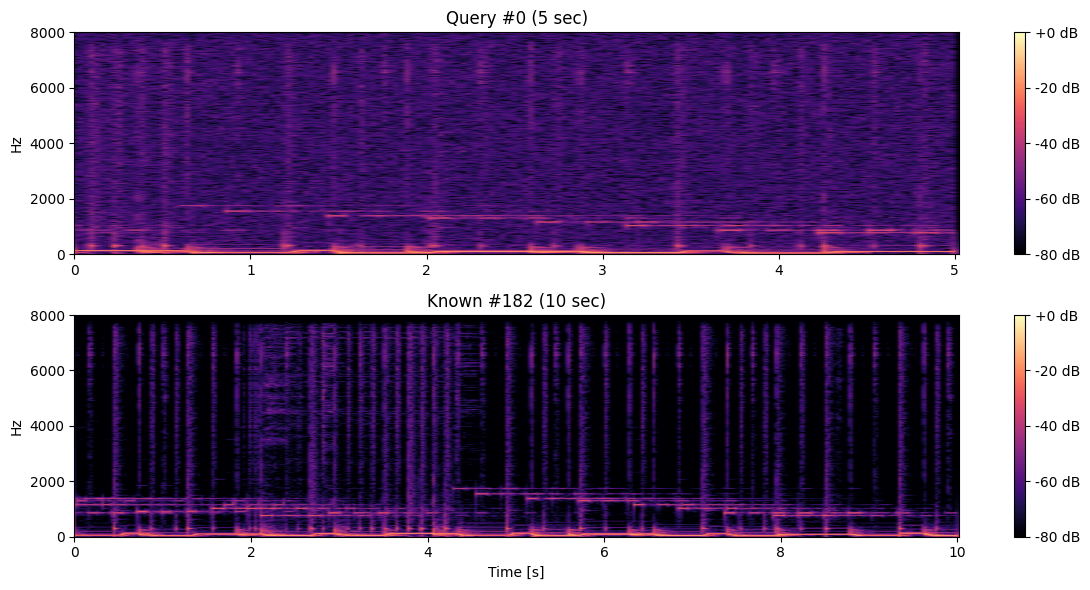

▶ Query #0:


▶ Known #182:


------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
------------------------------------------------------------------------------------------------------------------------------------------------------


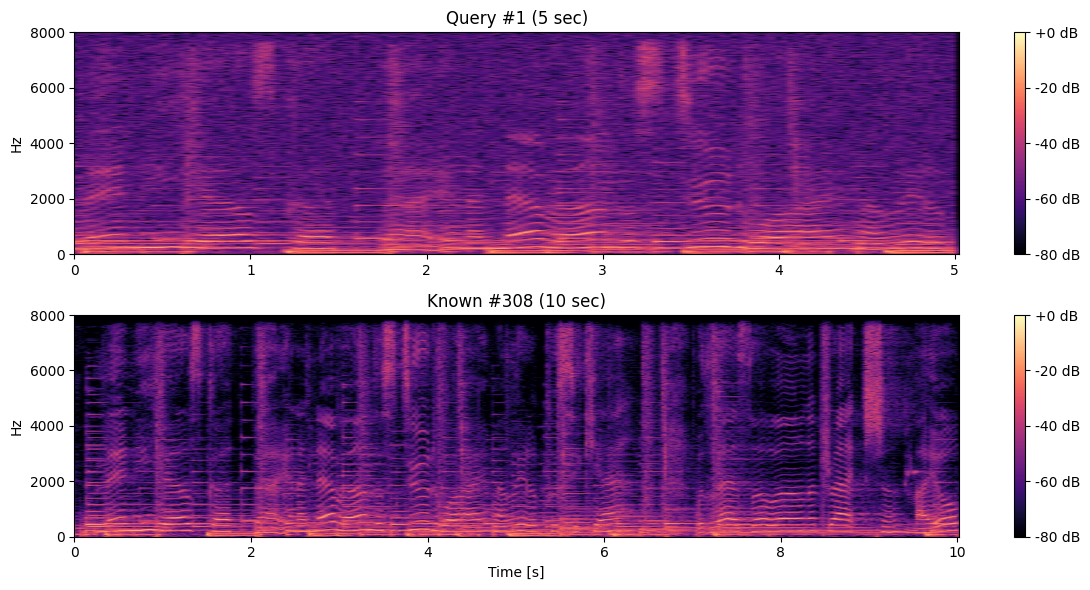

▶ Query #1:


▶ Known #308:


------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
------------------------------------------------------------------------------------------------------------------------------------------------------


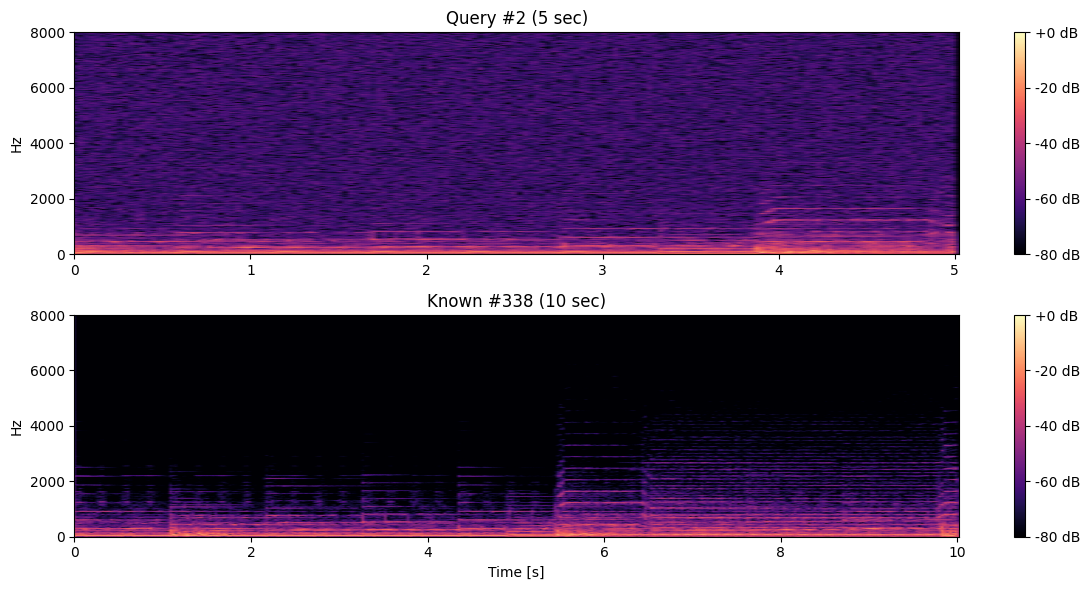

▶ Query #2:


▶ Known #338:


------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
------------------------------------------------------------------------------------------------------------------------------------------------------


In [48]:
for i in range(3):

    # Get query and its matching known signal stored in the loaded key.txt
    query_idx = i
    known_idx = key[query_idx]

    # Compute spectrograms we use shor-time Fourier transform
    f, t_q, x_q = signal.stft(valid_signals[query_idx], fs=Fs, nperseg=1024, noverlap=512)
    _, t_k, x_k = signal.stft(known_signals[known_idx], fs=Fs, nperseg=1024, noverlap=512)

    # Convert to dB
    spec_q = 20 * np.log10(np.abs(x_q) + 1e-10)
    spec_k = 20 * np.log10(np.abs(x_k) + 1e-10) # safety measure for zero division

    # Just plotting it nicely
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))
    im1 = ax1.pcolormesh(t_q, f, spec_q, shading='gouraud', cmap='magma', vmin=-80, vmax=0)
    ax1.set_ylabel('Hz')
    ax1.set_title(f'Query #{query_idx} (5 sec)')
    ax1.set_ylim([0, 8000])
    plt.colorbar(im1, ax=ax1, format='%+2.0f dB')

    im2 = ax2.pcolormesh(t_k, f, spec_k, shading='gouraud', cmap='magma', vmin=-80, vmax=0)
    ax2.set_ylabel('Hz')
    ax2.set_xlabel('Time [s]')
    ax2.set_title(f'Known #{known_idx} (10 sec)')
    ax2.set_ylim([0, 8000])
    plt.colorbar(im2, ax=ax2, format='%+2.0f dB')

    plt.tight_layout()
    plt.show()

    # Play audio
    print(f"▶ Query #{query_idx}:")
    display(Audio(valid_signals[query_idx], rate=Fs))

    print(f"▶ Known #{known_idx}:")
    display(Audio(known_signals[known_idx], rate=Fs))
    print("-" * 150)
    print("/" * 150)
    print("-" * 150)


Alright, now let's try our first method. By looking at a spectrogram we see it has two axes: frequency and time. As we know, the validation audios are not the same length as the known data, so we cannot directly compare signals along the time axis. But the similarity comparison along frequency axis should be possible, even though, the signals are not of the same length.  The validation signal is cropped part of the known signal, but they are expected to share "frequency profile", so let's try to compute some kind of similarity according to frequency profile of each signal. This profile is a 1D vector of size (513,), as we dont need all 1024 bins but only $\frac{n}{2} + 1$ (above we showed *signal.stft* has parameter *return_onesided* and we chose default *True*, as we don't want to do double computation for nothing).

The similarities will be computed with short-time Fourier transform same as above. For each known signal we take the magnitude spectrogram, sum each frequency bin over time, and store the resulting vector in a *known.profiles* list. For each validation signal we compute its own frequency profile and take the dot product with all known_profiles, which gives us a similarity matrix of shape 50×706. This matrix is then evaluated by the provided eval function, which converts it into Top‑1 and Top‑5 accuracy, and we also measure execution time because we care about how fast the method runs.



In [ ]:
def frequency_profile_similarity(test_valid, known_signals):
    # Frequency Profile - sum along time (axis=1)
    nperseg, noverlap = 1024, 512 #size of the windows, something reasonable later increased

    # create list of known profiles
    known_profiles = []
    for i in range(len(known_signals)):
        f, t, x = signal.stft(known_signals[i], fs=Fs, nperseg=nperseg, noverlap=noverlap) #stft
        spec = np.abs(x) # only keep amplitude same as before
        freq_profile = np.sum(spec, axis=1) #sum over time (along time axis), it returns (513,) vector as we only return half due to symmetry
        known_profiles.append(freq_profile)

    similarities = np.zeros((len(test_valid), len(known_signals))) # crate empty vector 50x706

    # for each test_valid sample, compute stft and compare
    for i in range(len(test_valid)):
        f, t, x = signal.stft(test_valid[i], fs=Fs, nperseg=nperseg, noverlap=noverlap)
        query_spec = np.abs(x)
        q_profile = np.sum(query_spec, axis=1)

        # compare query profile to each known_profile
        for j in range(len(known_signals)):
            k_profile = known_profiles[j]
            similarities[i, j] = np.dot(q_profile, k_profile)

    return similarities

start = time.time()
scores_matrix = frequency_profile_similarity(valid_signals, known_signals)
top1, top5 = eval(scores_matrix, key)
print(f"Top 1 accuracy {top1*100:.1f}%, Top 5 accuracy {top5*100:.1f}%, Time: {time.time()-start:.2f}s")

Top 1 accuracy 0.0%, Top 5 accuracy 4.0%, Time: 4.02s


Wow, this is complete failure top-1 is 0 % and top-5 is 4 %, but I have a feeling this method has potential. Let's visualize few frequency profiles of valid and paired known wavs. Maybe we see what is wrong.


The visualization is done in a visualize profile method which takes needed input arguments including number of plots n_plots. It plots few matching profiles according to key. The y axis is energy (the sum of frequencies over time) and x axis are frequencies.

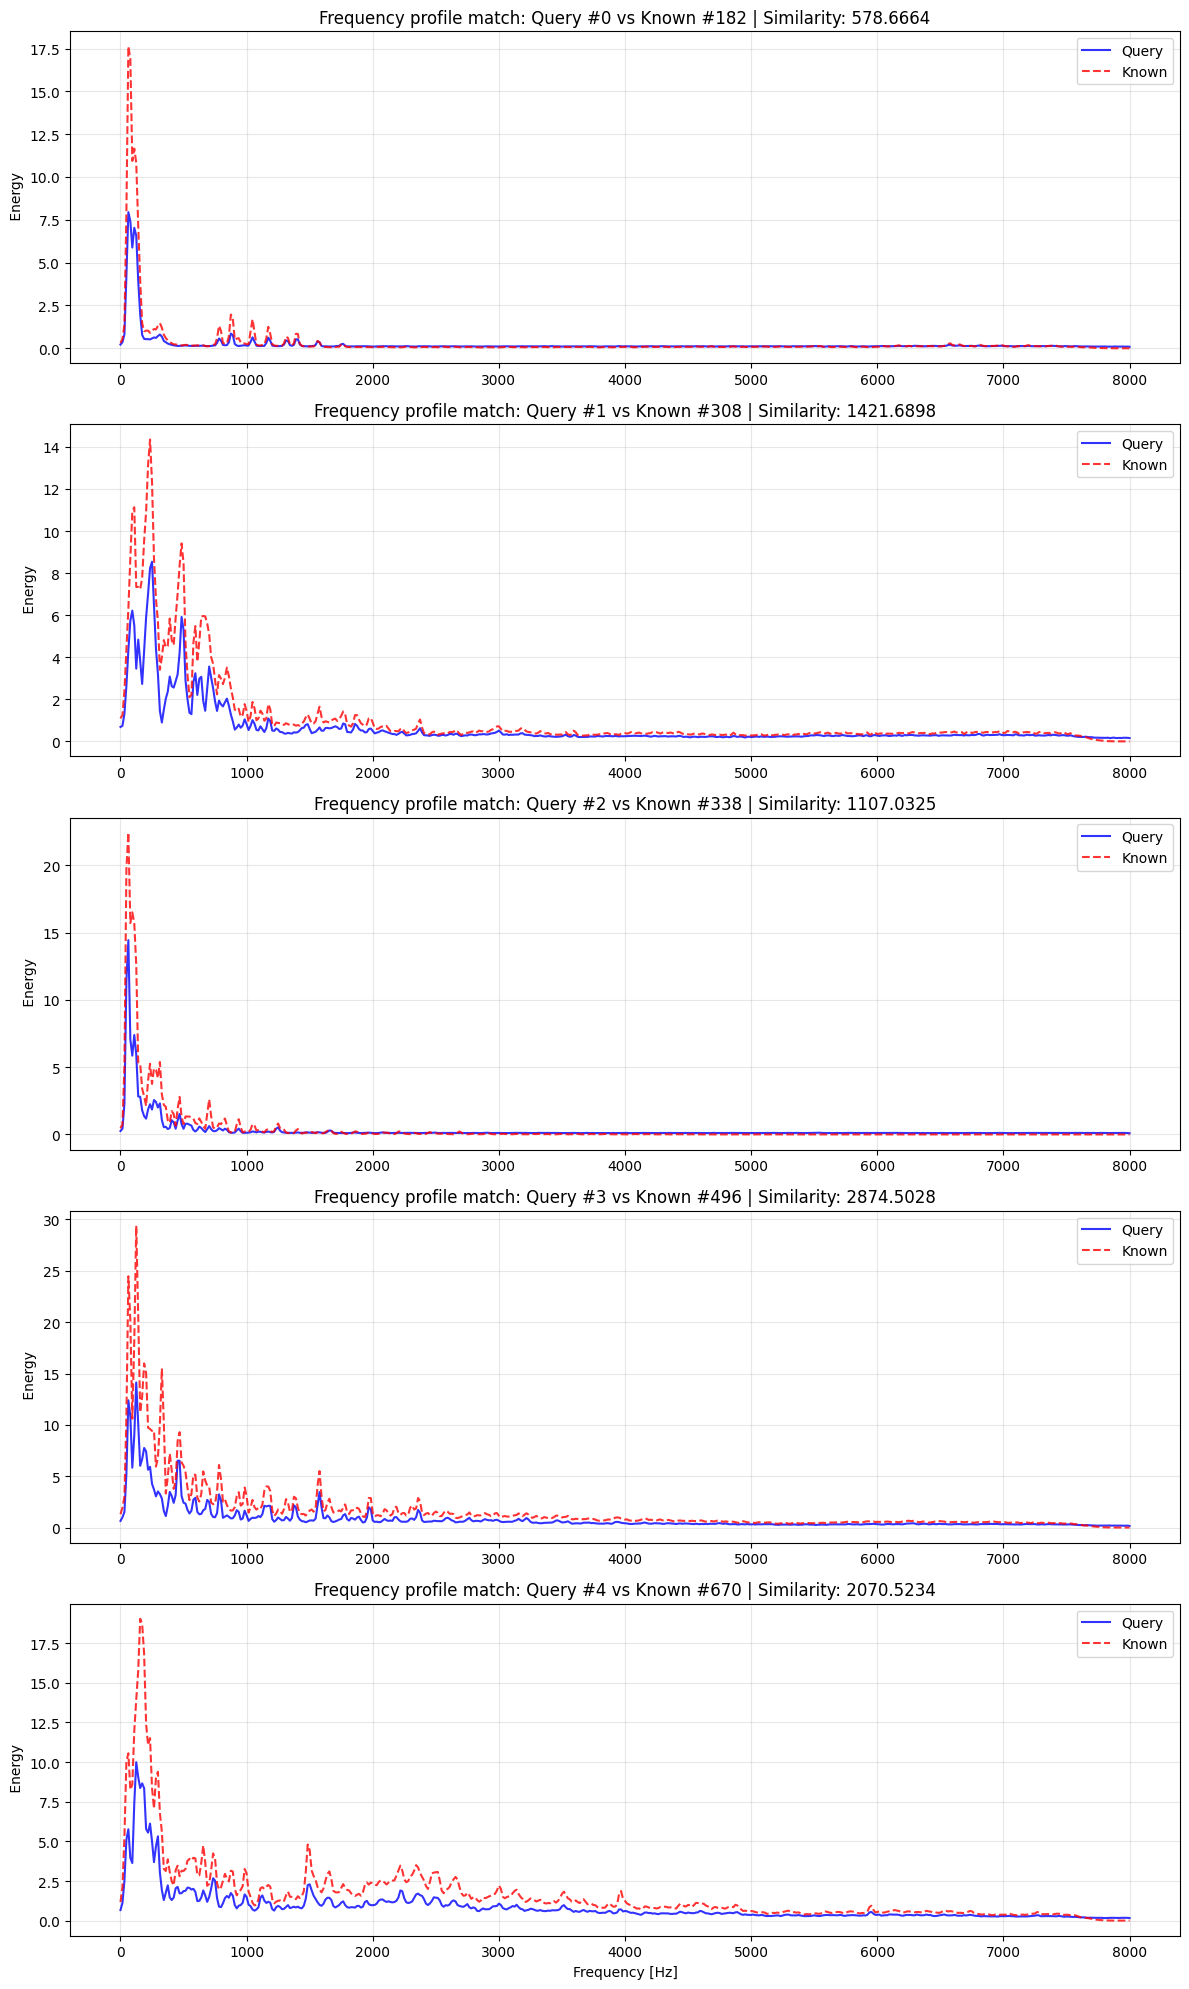

In [54]:
def visualize_profiles(n_plots, valid_signals, known_signals, key, fs=16000):

    nperseg, noverlap = 1024, 512

    # Setup plot
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 4 * n_plots), sharex=False)
    if n_plots == 1: axes = [axes] # Handle single plot case

    for i in range(n_plots):

        query_idx = i
        known_idx = key[query_idx] # Get correct match from key

        # query profile
        f, t, x = signal.stft(valid_signals[query_idx], fs=fs, nperseg=nperseg, noverlap=noverlap)
        spec = np.abs(x)
        q_profile = np.sum(spec, axis=1)
        # known profile
        f, t, x = signal.stft(known_signals[known_idx], fs=fs, nperseg=nperseg, noverlap=noverlap)
        query_spec = np.abs(x)
        k_profile = np.sum(query_spec, axis=1)

        # similarity
        similarity = np.dot(q_profile, k_profile)

        # Plot
        ax = axes[i]
        ax.plot(f, q_profile, label='Query', color='blue', alpha=0.8, linewidth=1.5)
        ax.plot(f, k_profile, label='Known', color='red', alpha=0.8, linewidth=1.5, linestyle='--')
        ax.set_title(f"Frequency profile match: Query #{query_idx} vs Known #{known_idx} | Similarity: {similarity:.4f}")
        ax.set_ylabel(" Energy")
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
    axes[-1].set_xlabel("Frequency [Hz]")
    plt.tight_layout()
    plt.show()

visualize_profiles(3, valid_signals, known_signals, key, Fs)


The plots look nice and they show us exactly what is wrong. The frequency profiles indeed look very similar between corresponding signals. The problem is they have very different absolute amounts of energy at each frequency. Even though the peaks are at the same positions, their magnitudes differ significantly—the 10-second known signal naturally accumulates roughly twice as much energy as the 5-second query. When computing *np.dot(q_profile, k_profile)* without normalization, the dot product is dominated by **magnitude rather than shape**. This means the algorithm favors signals with higher overall energy (louder or longer recordings) instead of matching the spectral pattern. As a result, every query tends to match the same "loudest" known tracks, leading to 0% accuracy.

So we need normalization. The solution is to apply **L2 (Euclidean) normalization** to the profiles. L2 normalization makes each frequency profile a unit vector (length = 1), preserving relative proportions while removing absolute magnitude. This makes our method invariant to signal length and amplitude. The dot product of two L2-normalized vectors is exactly cosine similarity, which measures the angle between them. Values close to 1 indicate high similarity, values close to 0 mean orthogonal (dissimilar) profiles. Both profiles are 513-dimensional vectors, we just compute their cosine similarity. Cosine similarity is widely used in NLP, information retrieval, and other AI domains precisely because it captures shape rather than scale, so why not use it here.

For good measure we are going to substract the DC bias in case there is some low frequency rumble which could disrupt our high dimensional vectors. It might be unneccessary as the L2 normalization "re-centers" the data anyway by making all vectors unit length.

So let's continue by normalizing and substracting DC bias.

In [ ]:
def frequency_profile_similarity_norm(test_valid, known_signals):
    # Frequency Profile - sum along time (axis=1)
    nperseg, noverlap = 1024, 512 #size of the windows, something reasonable later increased

    # create list of known profiles
    known_profiles = []
    for i in range(len(known_signals)):
        f, t, x = signal.stft(known_signals[i], fs=Fs, nperseg=nperseg, noverlap=noverlap) #stft
        spec = np.abs(x) # only keep amplitude same as before
        spec = spec - np.mean(spec) # DC bias
        freq_profile = np.sum(spec, axis=1) #sum over time (along time axis), it returns (513,) vector as we only return half due to symmetry

        #NORMALIZATION - key change
        norm = np.linalg.norm(freq_profile) #normalization L2 euklidian norm
        freq_profile = freq_profile / norm  #freq_profile normalized
        known_profiles.append(freq_profile)

    similarities = np.zeros((len(test_valid), len(known_signals))) # crate empty vector 50x706


    # for each test_valid sample, compute stft and compare
    for i in range(len(test_valid)):
        f, t, x = signal.stft(test_valid[i], fs=Fs, nperseg=nperseg, noverlap=noverlap)
        query_spec = np.abs(x)
        query_spec = query_spec - np.mean(query_spec)
        q_profile = np.sum(query_spec, axis=1)

        #NORMALIZATION - key change
        q_norm = np.linalg.norm(q_profile)
        q_profile = q_profile / q_norm

        # compare query profile to each known_profile
        for j in range(len(known_signals)):
            t_profile = known_profiles[j]
            similarities[i, j] = np.dot(q_profile, t_profile)

    return similarities

start = time.time()
scores_matrix = frequency_profile_similarity_norm(valid_signals, known_signals)
top1, top5 = eval(scores_matrix, key)
print(f"Top 1 accuracy {top1*100:.1f}%, Top 5 accuracy {top5*100:.1f}%, Time: {time.time()-start:.2f}s")

Top 1 accuracy 100.0%, Top 5 accuracy 100.0%, Time: 3.52s


The results are now just outstanding, which shows us our method works flawlessly for our validation data, it reaches perfect accuracy of 100 % top-1. It obviously wasn't first try, the normalization was added after completely failed attempts of top-5 accuracy of 4 %. It is also reasonably fast with time just around 4 seconds.

Let's visualize once more for verification.

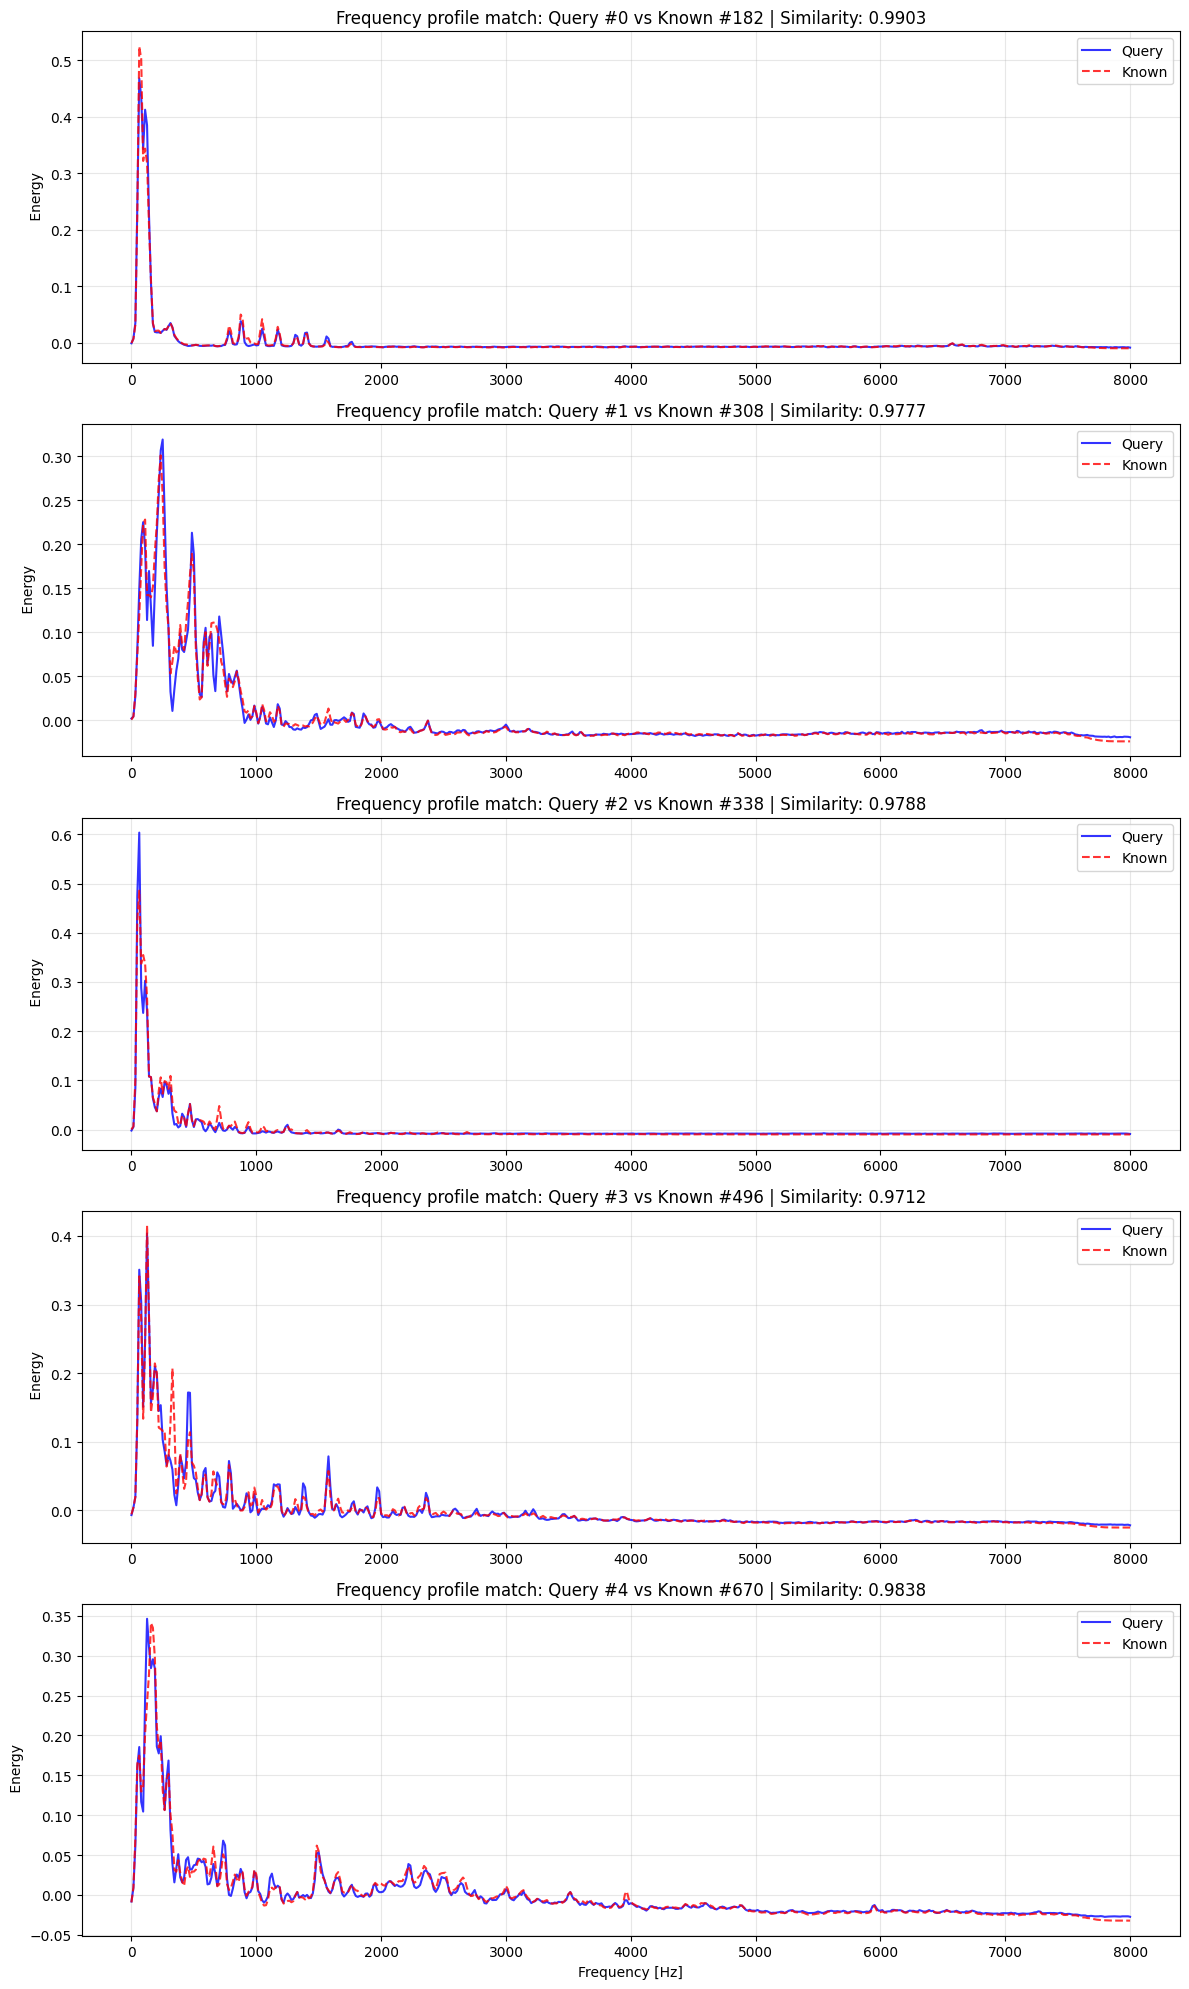

In [53]:
def visualize_normalized_profiles(n_plots, valid_signals, known_signals, key, fs=16000):

    nperseg, noverlap = 1024, 512

    # Setup plot
    fig, axes = plt.subplots(n_plots, 1, figsize=(12, 4 * n_plots), sharex=False)
    if n_plots == 1: axes = [axes] # Handle single plot case

    for i in range(n_plots):

        query_idx = i
        known_idx = key[query_idx] # Get correct match from key

        # query profile
        f, t, x = signal.stft(valid_signals[query_idx], fs=fs, nperseg=nperseg, noverlap=noverlap)
        query_spec = np.abs(x)
        query_spec = query_spec - np.mean(query_spec)
        q_profile = np.sum(query_spec, axis=1)
        q_profile = q_profile / np.linalg.norm(q_profile)
        # known profile
        f, t, x = signal.stft(known_signals[known_idx], fs=fs, nperseg=nperseg, noverlap=noverlap)
        spec = np.abs(x)
        spec = spec - np.mean(spec)
        k_profile = np.sum(spec, axis=1)
        k_profile = k_profile / np.linalg.norm(k_profile)


        # similarity
        similarity = np.dot(q_profile, k_profile)

        # Plot
        ax = axes[i]
        ax.plot(f, q_profile, label='Query', color='blue', alpha=0.8, linewidth=1.5)
        ax.plot(f, k_profile, label='Known', color='red', alpha=0.8, linewidth=1.5, linestyle='--')
        ax.set_title(f"Frequency profile match: Query #{query_idx} vs Known #{known_idx} | Similarity: {similarity:.4f}")
        ax.set_ylabel(" Energy")
        ax.grid(True, alpha=0.3)
        ax.legend(loc='upper right')
    axes[-1].set_xlabel("Frequency [Hz]")
    plt.tight_layout()
    plt.show()

visualize_normalized_profiles(3, valid_signals, known_signals, key, Fs)


The verification shows a nice unit vector scale and signals overlapping each other. **Our work could be done at this point.**


Although this result is good, I have a feeling that if the data were noisier or distorted differently, this could result in poor performance of our solution.


In my opinion the dataset is not challenging enough to discover weaknesses of the method and to really find its limits. It might be sufficient for the project itself, but I want to go deeper and see how the method performs on more "hostile" data.


I generated three extra degradation levels to mess up the audio in a controlled, realistic way, from less challenging to almost impossible to identify. I also plot spectrograms and add players so you can both see and hear what’s going on.

*   Level 1: Adds moderate white noise (SNR ~10 dB) and a 4 kHz low-pass filter, like a slightly noisy mic or old consumer gear, still very listenable.
*   Level 2: More noise (SNR ~5 dB), a 50–3500 Hz band-pass, plus small realistic timing jitter (3 µs) to imitate poor clocks in cheap digital devices. It is nasty, but still realistic.
*   Level 3: Noise as strong as the signal (SNR ~0 dB), a tight 100–3000 Hz band-pass, plus ±3% time-stretch, random gain (0.5–1.5×), and hard clipping at ±0.8. It simulates a brutally mangled transmission, worst-case scenario, very unlikely in real life but useful for stress-testing.




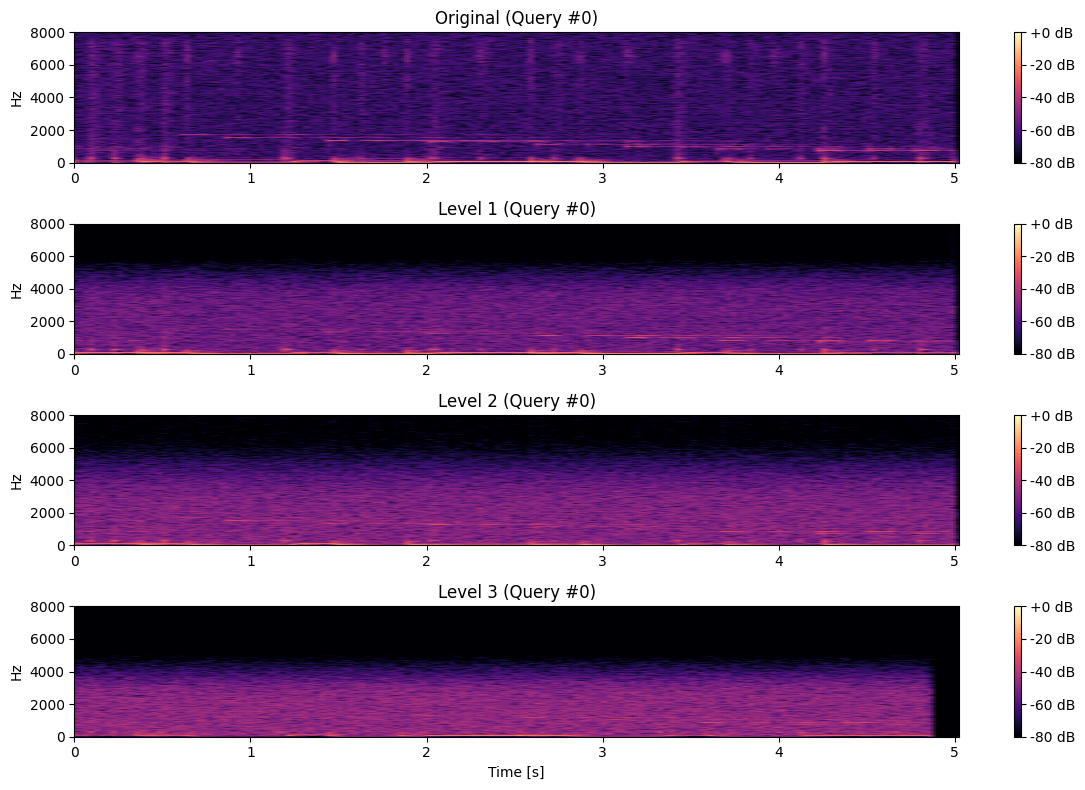

▶ Original:


▶ Level 1:


▶ Level 2:


▶ Level 3:


------------------------------------------------------------------------------------------------------------------------------------------------------
//////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
------------------------------------------------------------------------------------------------------------------------------------------------------


In [64]:
def degrade_signal(clean_signal, degradation_level, fs=16000):
    degraded = clean_signal.copy()

    if degradation_level == 1:
        noise = np.random.randn(len(degraded)) * np.sqrt(np.mean(degraded**2) / 10)
        degraded = signal.sosfilt(signal.butter(4, 4000, 'low', fs=fs, output='sos'), degraded + noise)

    elif degradation_level == 2:
        noise = np.random.randn(len(degraded)) * np.sqrt(np.mean(degraded**2) / 3.16)
        degraded = signal.sosfilt(signal.butter(3, 3500, 'low', fs=fs, output='sos'),
                                  signal.sosfilt(signal.butter(3, 50, 'high', fs=fs, output='sos'), degraded + noise))
        jitter = np.random.randn(len(degraded)) * (3.0 / (1e6 / fs))
        indices = np.clip(np.arange(len(degraded)) + jitter, 0, len(degraded) - 1)
        degraded = interp1d(np.arange(len(degraded)), degraded, kind='linear')(indices)

    elif degradation_level == 3:
        noise = np.random.randn(len(degraded)) * np.sqrt(np.mean(degraded**2))
        degraded = signal.sosfilt(signal.butter(5, 3000, 'low', fs=fs, output='sos'),
                                  signal.sosfilt(signal.butter(5, 100, 'high', fs=fs, output='sos'), degraded + noise))
        stretch = np.random.uniform(0.97, 1.03)
        new_idx = np.linspace(0, len(degraded)-1, int(len(degraded) / stretch))
        degraded = interp1d(np.arange(len(degraded)), degraded, kind='linear')(new_idx)
        degraded = degraded[:len(clean_signal)] if len(degraded) > len(clean_signal) else \
                   np.pad(degraded, (0, len(clean_signal) - len(degraded)))
        degraded = np.clip(degraded * np.random.uniform(0.5, 1.5), -0.8, 0.8)

    return degraded

# create degraded datasets
valid_degraded_L1 = np.array([degrade_signal(s, 1) for s in valid_signals])
valid_degraded_L2 = np.array([degrade_signal(s, 2) for s in valid_signals])
valid_degraded_L3 = np.array([degrade_signal(s, 3) for s in valid_signals])

# visualize first 3 samples
for i in range(1):
    query_idx, known_idx = i, key[i]

    #Compute spectrograms
    f, t_q, x_q = signal.stft(valid_signals[query_idx], fs=Fs, nperseg=1024, noverlap=512)
    _, t_d1, x_d1 = signal.stft(valid_degraded_L1[query_idx], fs=Fs, nperseg=1024, noverlap=512)
    _, t_d2, x_d2 = signal.stft(valid_degraded_L2[query_idx], fs=Fs, nperseg=1024, noverlap=512)
    _, t_d3, x_d3 = signal.stft(valid_degraded_L3[query_idx], fs=Fs, nperseg=1024, noverlap=512)

    spec_q = 20 * np.log10(np.abs(x_q) + 1e-10)
    spec_d1 = 20 * np.log10(np.abs(x_d1) + 1e-10)
    spec_d2 = 20 * np.log10(np.abs(x_d2) + 1e-10)
    spec_d3 = 20 * np.log10(np.abs(x_d3) + 1e-10)

    # Plot it all
    fig, axes = plt.subplots(4, 1, figsize=(12, 8))
    for ax, t, spec, title in zip(axes, [t_q, t_d1, t_d2, t_d3],
                                   [spec_q, spec_d1, spec_d2, spec_d3],
                                   ['Original', 'Level 1', 'Level 2', 'Level 3']):
        im = ax.pcolormesh(t, f, spec, shading='gouraud', cmap='magma', vmin=-80, vmax=0)
        ax.set_ylabel('Hz')
        ax.set_title(f'{title} (Query #{query_idx})')
        ax.set_ylim([0, 8000])
        plt.colorbar(im, ax=ax, format='%+2.0f dB')
    axes[-1].set_xlabel('Time [s]')
    plt.tight_layout()
    plt.show()

    # audio players
    print(f"▶ Original:"); display(Audio(valid_signals[query_idx], rate=Fs))
    print(f"▶ Level 1:"); display(Audio(valid_degraded_L1[query_idx], rate=Fs))
    print(f"▶ Level 2:"); display(Audio(valid_degraded_L2[query_idx], rate=Fs))
    print(f"▶ Level 3:"); display(Audio(valid_degraded_L3[query_idx], rate=Fs))
    print("-" * 150)
    print("/" * 150)
    print("-" * 150)


Next, we plot the frequency profiles for the original signal and all three degradation levels. This lets us see, in a single 1D view, how noise, filtering, jitter, and time‑stretch affect the long‑term spectral shape of each clip.

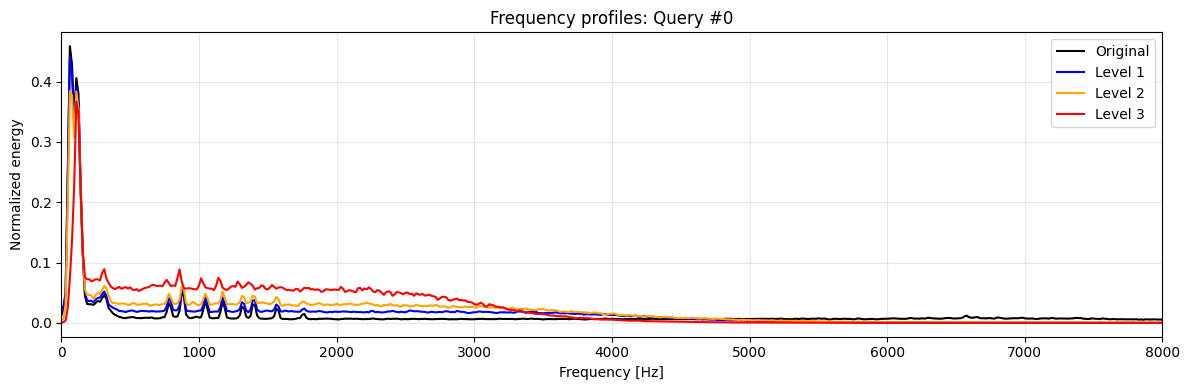

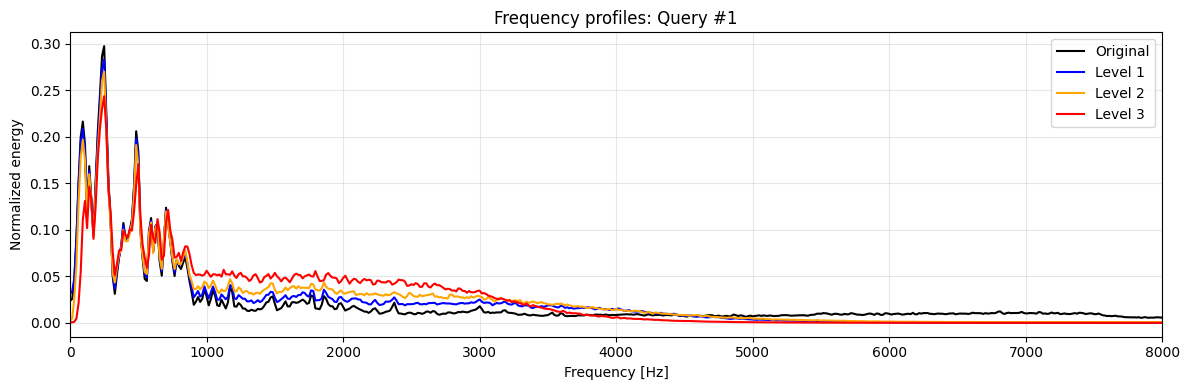

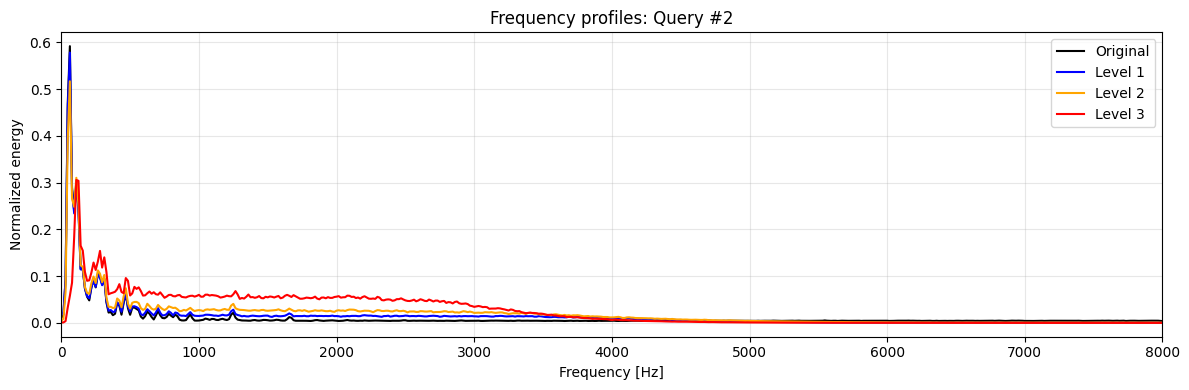

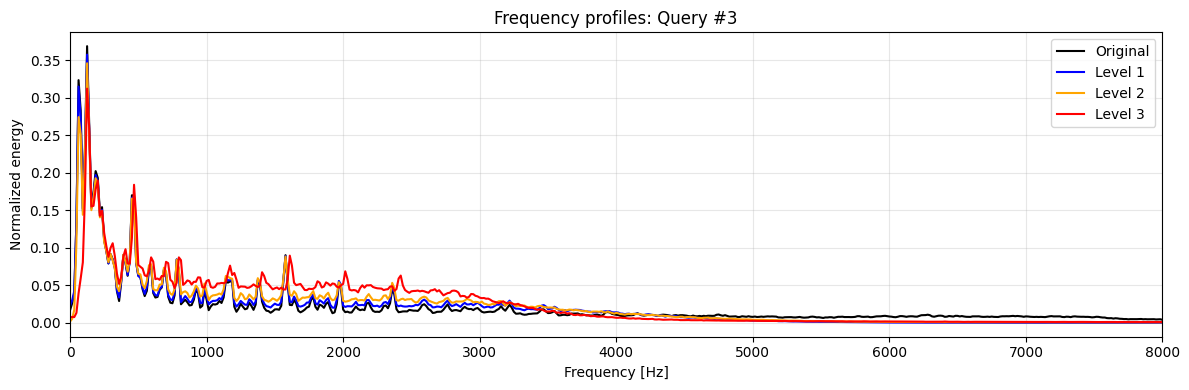

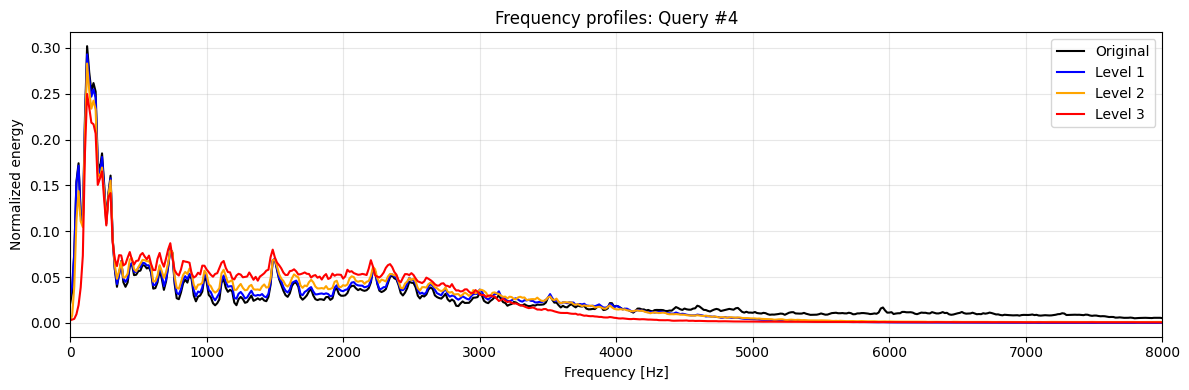

In [56]:
def visualize_degradation_profiles(valid_signals, valid_L1, valid_L2, valid_L3, key, fs=16000):
    nperseg, noverlap = 1024, 512

    for query_idx in range(5):
        # STFTs
        f, _, X_orig = signal.stft(valid_signals[query_idx], fs=fs, nperseg=nperseg, noverlap=noverlap)
        _, _, X_L1   = signal.stft(valid_L1[query_idx], fs=fs, nperseg=nperseg, noverlap=noverlap)
        _, _, X_L2   = signal.stft(valid_L2[query_idx], fs=fs, nperseg=nperseg, noverlap=noverlap)
        _, _, X_L3   = signal.stft(valid_L3[query_idx], fs=fs, nperseg=nperseg, noverlap=noverlap)

        # normalized profiles fore each level
        def profile(X):
            spec = np.abs(X)
            p = np.sum(spec, axis=1)
            return p / (np.linalg.norm(p) + 1e-10)

        p_orig = profile(X_orig)
        p_L1 = profile(X_L1)
        p_L2 = profile(X_L2)
        p_L3 = profile(X_L3)

        # Plot
        plt.figure(figsize=(12, 4))
        plt.plot(f, p_orig, label='Original', color='black')
        plt.plot(f, p_L1, label='Level 1', color='blue')
        plt.plot(f, p_L2, label='Level 2', color='orange')
        plt.plot(f, p_L3, label='Level 3', color='red')
        plt.title(f"Frequency profiles: Query #{query_idx}")
        plt.xlabel("Frequency [Hz]")
        plt.ylabel("Normalized energy")
        plt.xlim(0, 8000)
        plt.grid(alpha=0.3)
        plt.legend()
        plt.tight_layout()
        plt.show()

# call with your arrays
visualize_degradation_profiles(valid_signals, valid_degraded_L1, valid_degraded_L2, valid_degraded_L3, key, Fs)


We can clearly see substantial differences between the profiles. Level 1 stays very close to the original; the added moderate noise only slightly raises the noise floor, so the main peaks remain sharp and in the same places.​

Level 2 adds stronger noise and applies a 50–3500 Hz band‑pass, which narrows the spectrum and fills it with broadband energy, so the characteristic peaks are noticeably flattened and less prominent.​

At Level 3 the peaks are even flatter and less distinct. Small random time‑stretching (about ±3%) smears spectral detail in time–frequency. Random gain changes followed by hard clipping (−0.8 to 0.8) further introduce strong nonlinear distortion. The 100–3000 Hz band‑pass further suppresses low and high frequencies, where much of the signal's energy originally resides. Together, these effects make Level 3 clips extremely hard to identify for our frequency‑profile method.​

Now let's evaluate our method on these degraded datasets.

In [57]:
# Benchmark on all levels

scores_matrix = frequency_profile_similarity_norm(valid_signals, known_signals)
top1, top5 = eval(scores_matrix, key)
print(f"Original:  Top-1: {top1*100:.1f}%, Top-5: {top5*100:.1f}%")

scores_matrix = frequency_profile_similarity_norm(valid_degraded_L1, known_signals)
top1, top5 = eval(scores_matrix, key)
print(f"Level 1:   Top-1: {top1*100:.1f}%, Top-5: {top5*100:.1f}%")

scores_matrix = frequency_profile_similarity_norm(valid_degraded_L2, known_signals)
top1, top5 = eval(scores_matrix, key)
print(f"Level 2:   Top-1: {top1*100:.1f}%, Top-5: {top5*100:.1f}%")

scores_matrix = frequency_profile_similarity_norm(valid_degraded_L3, known_signals)
top1, top5 = eval(scores_matrix, key)
print(f"Level 3:   Top-1: {top1*100:.1f}%, Top-5: {top5*100:.1f}%")

Original:  Top-1: 100.0%, Top-5: 100.0%
Level 1:   Top-1: 98.0%, Top-5: 100.0%
Level 2:   Top-1: 72.0%, Top-5: 90.0%
Level 3:   Top-1: 20.0%, Top-5: 36.0%


The results are very much in line with expectations.

On original level as well as on first level the frequency_profile performs very well, the effects are not strong enough to disturb identification (no lower frequency filtration). Level 2 still behaves reasonably well with Top‑1 accuracy of 72%, but the combination of stronger noise, 50–3500 Hz band‑pass, and timing jitter already starts to flatten the characteristic peaks in the profile and lowers accuracy.

Level 3 then combines the strongest noise, tighter 100–3000 Hz band‑pass, time‑stretch, and clipping, which severely distorts the long‑term spectral envelope; as a result the method becomes almost “lethal” for frequency profiles, with Top‑5 accuracy dropping to 36%.

We can compensate a little and improve the frequency profile method by increasing the window size, meaning we will effectively extend number of frequency bins and therefore make method more robust.

```
nperseg, noverlap = 4096, 2048
```

Additionally, we apply a 20–5000 Hz band‑pass before forming the profile, which removes frequency regions where our plots showed almost no useful energy.  It wont likely help much with accuracy but could slightly reduce computation without affecting accuracy.​

This is done by the *apply_frequency_filter* method, which converts the desired frequency range [min_freq, max_freq] into STFT bin indices using the frequency resolution $\frac{Fs}{nperseg}$, and then returns only those rows (frequency bins) of the spectrogram while keeping all time frames intact.

In [32]:
def apply_frequency_filter(spec, fs, nperseg, min_freq, max_freq):
    freq_resolution = fs / nperseg
    n_bins = spec.shape[0]
    min_bin = max(0, int(min_freq / freq_resolution))
    max_bin = min(n_bins, int(max_freq / freq_resolution))
    return spec[min_bin:max_bin, :]

In [60]:
def frequency_profile_similarity_2(test_valid, known_signals):
    # window and filter frequencies the window is larger
    nperseg, noverlap = 4096, 2048
    MIN_FREQ, MAX_FREQ = 20, 5000

    # create list of known profiles
    known_profiles = []
    for i in range(len(known_signals)):
        f, t, x = signal.stft(known_signals[i], fs=Fs, nperseg=nperseg, noverlap=noverlap) #stft
        spec = np.abs(x) # only keep amplitude same as before
        #here comes filtration
        spec = apply_frequency_filter(spec, Fs, nperseg, MIN_FREQ, MAX_FREQ)
        spec = spec - np.mean(spec) # DC bias
        freq_profile = np.sum(spec, axis=1) #sum over time (along time axis), it returns (513,) vector as we only return half due to symmetry
        norm = np.linalg.norm(freq_profile) #normalization L2 euklidian norm
        freq_profile = freq_profile / norm  #freq_profile normalized
        known_profiles.append(freq_profile)

    similarities = np.zeros((len(test_valid), len(known_signals))) # crate empty vector 50x706


    # for each test_valid sample, compute stft and compare
    for i in range(len(test_valid)):
        f, t, x = signal.stft(test_valid[i], fs=Fs, nperseg=nperseg, noverlap=noverlap)
        query_spec = np.abs(x)
        # here comes the filtration
        query_spec = apply_frequency_filter(query_spec, Fs, nperseg, MIN_FREQ, MAX_FREQ)
        query_spec = query_spec - np.mean(query_spec)
        q_profile = np.sum(query_spec, axis=1)
        q_norm = np.linalg.norm(q_profile)
        q_profile = q_profile / q_norm

        # compare query profile to each known_profile
        for j in range(len(known_signals)):
            t_profile = known_profiles[j]
            similarities[i, j] = np.dot(q_profile, t_profile)

    return similarities

start = time.time()
scores_matrix = frequency_profile_similarity_norm(valid_signals, known_signals)
top1, top5 = eval(scores_matrix, key)
print(f"Top 1 accuracy {top1*100:.1f}%, Top 5 accuracy {top5*100:.1f}%, Time: {time.time()-start:.2f}s")

Top 1 accuracy 100.0%, Top 5 accuracy 100.0%, Time: 3.42s


We perform evaluation again...

In [59]:
# Benchmark on all levels

scores_matrix = frequency_profile_similarity_2(valid_signals, known_signals)
top1, top5 = eval(scores_matrix, key)
print(f"Original:  Top-1: {top1*100:.1f}%, Top-5: {top5*100:.1f}%")

scores_matrix = frequency_profile_similarity_2(valid_degraded_L1, known_signals)
top1, top5 = eval(scores_matrix, key)
print(f"Level 1:   Top-1: {top1*100:.1f}%, Top-5: {top5*100:.1f}%")

scores_matrix = frequency_profile_similarity_2(valid_degraded_L2, known_signals)
top1, top5 = eval(scores_matrix, key)
print(f"Level 2:   Top-1: {top1*100:.1f}%, Top-5: {top5*100:.1f}%")

scores_matrix = frequency_profile_similarity_2(valid_degraded_L3, known_signals)
top1, top5 = eval(scores_matrix, key)
print(f"Level 3:   Top-1: {top1*100:.1f}%, Top-5: {top5*100:.1f}%")

Original:  Top-1: 98.0%, Top-5: 100.0%
Level 1:   Top-1: 98.0%, Top-5: 100.0%
Level 2:   Top-1: 96.0%, Top-5: 98.0%
Level 3:   Top-1: 28.0%, Top-5: 36.0%


As we can see, we made our method a bit more robust on level two and increased our top-1 to astonishing 96 %. Level three stayed almost the same and was improved by just 2 % or so. The window seemed to help a lot, however, we cannot increase the window further as the computation time already doubled and we want fast processing.

Additionally, there is a fundamental time-frequency trade-off in STFT: larger windows give better frequency resolution but worse time resolution. At 4096 samples (256 ms), we already capture sufficient spectral detail (~4 Hz resolution) to resolve fundamentals and harmonics. It already might be a little too high. Going larger would blur rapid musical events like drum hits or note onsets. It would reduce the number of time frames available for averaging (making the profile less statistically robust), and significantly increase computation time.

This will now serve as our final method, that we will use to compute our matrix for final testing data.

In [62]:
# # YOUR CODE COMES HERE ! Your task is to produce a matrix 50 x 706 with similarity measures
def compute_similarity_matrix(test_valid, known_signals):
    # window and filter frequencies
    nperseg, noverlap = 4096, 2048
    MIN_FREQ, MAX_FREQ = 50, 5000
    # create list of known profiles
    known_profiles = []
    for i in range(len(known_signals)):
        f, t, x = signal.stft(known_signals[i], fs=Fs, nperseg=nperseg, noverlap=noverlap) #stft
        spec = np.abs(x) # only keep amplitude same as before
        spec = apply_frequency_filter(spec, Fs, nperseg, MIN_FREQ, MAX_FREQ) #FIltering
        spec = spec - np.mean(spec) # DC bias
        freq_profile = np.sum(spec, axis=1) #sum over time (along time axis), it returns (513,) vector as we only return half due to symmetry
        norm = np.linalg.norm(freq_profile) #normalization L2 euklidian norm
        freq_profile = freq_profile / norm  #freq_profile normalized
        known_profiles.append(freq_profile)

    similarities = np.zeros((len(test_valid), len(known_signals))) # crate empty vector 50x706

    # for each test_valid sample, compute stft and compare
    for i in range(len(test_valid)):
        f, t, x = signal.stft(test_valid[i], fs=Fs, nperseg=nperseg, noverlap=noverlap)
        query_spec = np.abs(x)
        query_spec = apply_frequency_filter(query_spec, Fs, nperseg, MIN_FREQ, MAX_FREQ)
        query_spec = query_spec - np.mean(query_spec)
        q_profile = np.sum(query_spec, axis=1)
        q_norm = np.linalg.norm(q_profile)
        q_profile = q_profile / q_norm

        # compare query profile to each known_profile
        for j in range(len(known_signals)):
            t_profile = known_profiles[j]
            similarities[i, j] = np.dot(q_profile, t_profile)

    return similarities

In [63]:
# NOW on YOUR DATA ! Your task is to produce a matrix 50 x 706 with similarity measures

# load your data
N_eval = 50; duration_eval = 5; no_samples_eval = Fs * duration_eval

eval_signals=np.zeros([N_eval, no_samples_eval]); load_data(eval_signals, login, N_eval, no_samples_eval)
#display(Audio(valid_signals[45], rate=Fs))

# YOUR CODE COMES HERE ! Your task is to produce a matrix 50 x 706 with similarity measures

# complete stupid dolution just for testing the export of file with results ...
scores_matrix = compute_similarity_matrix(eval_signals, known_signals)

# export it
np.savetxt("eval.txt", scores_matrix)

# to download it in Google Colab click on the folder icon in the left column, find eval.txt and download it as usually.
